In [4]:
# Install required packages
%pip install tensorflow opencv-python scikit-learn matplotlib pandas tqdm

Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import glob
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# Set random seeds
tf.random.set_seed(42)
np.random.seed(42)

In [6]:
def find_data_directories(data_path):
    """Find train/val/test directories in the data path"""
    possible_paths = [
        os.path.join(data_path, 'train'),
        os.path.join(data_path, 'Train'),
        data_path
    ]
    
    for path in possible_paths:
        if os.path.exists(path):
            print(f"Found directory: {path}")
            return path
    raise FileNotFoundError(f"Could not find data directories in {data_path}")

In [7]:
def load_yolo_annotations(img_path, img_shape):
    """Convert YOLO format to segmentation mask"""
    annotation_path = img_path.replace('images', 'labels').replace('.jpg', '.txt')
    
    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    
    if os.path.exists(annotation_path):
        try:
            with open(annotation_path, 'r') as f:
                lines = f.readlines()
                
            for line in lines:
                data = line.strip().split()
                if len(data) >= 5:
                    x_center, y_center, width, height = map(float, data[1:5])
                    
                    h, w = img_shape[:2]
                    x_center *= w
                    y_center *= h
                    width *= w
                    height *= h
                    
                    x1 = max(0, int(x_center - width/2))
                    y1 = max(0, int(y_center - height/2))
                    x2 = min(w, int(x_center + width/2))
                    y2 = min(h, int(y_center + height/2))
                    
                    if x2 > x1 and y2 > y1:
                        mask[y1:y2, x1:x2] = 1
        except Exception as e:
            print(f"Error processing annotation {annotation_path}: {e}")
                
    return mask

In [8]:
def load_complete_dataset(data_path, img_size=(256, 256)):
    """Load train, validation, and test datasets"""
    
    def load_split(split_path):
        """Load images and masks from a specific split (train/valid/test)"""
        images_path = os.path.join(split_path, 'images')
        labels_path = os.path.join(split_path, 'labels')
        
        if not os.path.exists(images_path):
            print(f"Warning: {images_path} does not exist")
            return [], []
        
        image_files = glob.glob(os.path.join(images_path, '*.jpg')) + glob.glob(os.path.join(images_path, '*.png'))
        
        images = []
        masks = []
        
        for img_file in image_files:
            try:
                # Load image
                image = cv2.imread(img_file)
                if image is None:
                    continue
                    
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, img_size)
                image = image.astype(np.float32) / 255.0
                
                # Load corresponding mask from YOLO annotations
                mask = load_yolo_annotations(img_file, image.shape)
                mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)
                mask = mask.astype(np.float32)
                
                images.append(image)
                masks.append(mask)
                
            except Exception as e:
                print(f"Error processing {img_file}: {e}")
                continue
        
        images = np.array(images)
        masks = np.array(masks)
        masks = np.expand_dims(masks, -1)
        
        print(f"Loaded {len(images)} samples from {split_path}")
        return images, masks
    
    # Load all splits
    train_path = os.path.join(data_path, 'train')
    valid_path = os.path.join(data_path, 'valid') 
    test_path = os.path.join(data_path, 'test')
    
    print("Loading dataset splits...")
    X_train, y_train = load_split(train_path)
    X_valid, y_valid = load_split(valid_path)
    X_test, y_test = load_split(test_path)
    
    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)

In [9]:
def create_unet_model(input_size=(256, 256, 3), learning_rate=0.001, optimizer='adam'):
    """Create U-Net model with configurable hyperparameters"""
    inputs = keras.Input(input_size)
    
    # Downsample
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x1 = x
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x2 = x
    x = layers.MaxPooling2D(2)(x)
    
    # Bottleneck
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    
    # Upsample
    x = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(x)
    x = layers.concatenate([x, x2])
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    
    x = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(x)
    x = layers.concatenate([x, x1])
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    
    # Output
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [10]:
def calculate_iou(y_true, y_pred):
    """Calculate Intersection over Union"""
    y_pred_binary = (y_pred > 0.5).astype(np.float32)
    intersection = np.sum(y_true * y_pred_binary)
    union = np.sum(y_true) + np.sum(y_pred_binary) - intersection
    return intersection / (union + 1e-7)

def calculate_metrics(y_true, y_pred):
    """Calculate precision, recall, and F1-score"""
    y_true_flat = y_true.flatten()
    y_pred_flat = (y_pred.flatten() > 0.5).astype(np.int32)
    
    if np.sum(y_true_flat) == 0 and np.sum(y_pred_flat) == 0:
        return 1.0, 1.0, 1.0
    
    precision = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    recall = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0)
    
    return precision, recall, f1

In [11]:
def run_kfold_cross_validation(data_path, n_splits=3, epochs=5, batch_size=8, 
                              learning_rate=0.001, optimizer='adam', max_samples=500):  # ← ADD THIS
    """Run K-Fold Cross Validation using only training data"""
    print("=" * 70)
    print("EXPERIMENT 1: K-FOLD CROSS VALIDATION (Training Data Only)")
    print("=" * 70)
    
    # Load only training data for K-Fold - WITH LIMIT
    (X_train_full, y_train_full), _, _ = load_complete_dataset(data_path)
    
    # ↓ ADD THESE LINES TO LIMIT DATASET SIZE
    if max_samples and len(X_train_full) > max_samples:
        X_train = X_train_full[:max_samples]
        y_train = y_train_full[:max_samples]
        print(f"Using limited dataset: {len(X_train)} samples (was {len(X_train_full)})")
    else:
        X_train = X_train_full
        y_train = y_train_full
    
    # Initialize K-Fold on training data
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
        print(f"Fold {fold + 1}/{n_splits}")
        print("-" * 50)
        
        # Split training data for this fold
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        
        # Create and train model
        model = create_unet_model(
            learning_rate=learning_rate,
            optimizer=optimizer
        )
        
        # Train model
        history = model.fit(
            X_fold_train, y_fold_train,
            validation_data=(X_fold_val, y_fold_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1  # ← Change to 1 to see progress
        )
        
        # Evaluate model
        y_pred = model.predict(X_fold_val, verbose=0)
        
        # Calculate metrics
        iou = calculate_iou(y_fold_val, y_pred)
        precision, recall, f1 = calculate_metrics(y_fold_val, y_pred)
        val_accuracy = history.history['val_accuracy'][-1]
        val_loss = history.history['val_loss'][-1]
        
        fold_result = {
            'fold': fold + 1,
            'val_accuracy': val_accuracy,
            'val_loss': val_loss,
            'iou': iou,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
        fold_results.append(fold_result)
        
        print(f"Fold {fold + 1} Results:")
        print(f"  Val Accuracy: {val_accuracy:.4f}")
        print(f"  IoU: {iou:.4f}")
        print(f"  F1-Score: {f1:.4f}")
    
    # Calculate mean and std across folds
    results_df = pd.DataFrame(fold_results)
    mean_results = results_df.mean()
    std_results = results_df.std()
    
    print("\nK-Fold Cross Validation Summary (Training Data):")
    print(f"Validation Accuracy: {mean_results['val_accuracy']:.4f} ± {std_results['val_accuracy']:.4f}")
    print(f"IoU: {mean_results['iou']:.4f} ± {std_results['iou']:.4f}")
    print(f"F1-Score: {mean_results['f1_score']:.4f} ± {std_results['f1_score']:.4f}")
    
    return fold_results, results_df

In [20]:
def run_hyperparameter_tuning(data_path, tuning_epochs=10):
    """Run hyperparameter tuning using train/validation splits"""
    print("\n" + "=" * 70)
    print("EXPERIMENT 2: HYPERPARAMETER TUNING (Train/Validation Data)")
    print("=" * 70)
    
    # Load train and validation data
    (X_train, y_train), (X_val, y_val), _ = load_complete_dataset(data_path)
    
    hyperparameters = {
        'learning_rate': [0.001, 0.0005],
        'batch_size': [16, 32],
        'optimizer': ['adam']
    }
    
    print(f"Using {len(X_train)} training samples, {len(X_val)} validation samples")
    
    tuning_results = []
    experiment_number = 1
    total_experiments = len(hyperparameters['learning_rate']) * len(hyperparameters['batch_size']) * len(hyperparameters['optimizer'])
    
    for lr in hyperparameters['learning_rate']:
        for batch_size in hyperparameters['batch_size']:
            for optimizer in hyperparameters['optimizer']:
                
                print(f"Experiment {experiment_number}/{total_experiments}")
                print(f"  Learning Rate: {lr}, Batch Size: {batch_size}, Optimizer: {optimizer}")
                
                model = create_unet_model(
                    learning_rate=lr,
                    optimizer=optimizer
                )
                
                # Train on training data, validate on validation data
                history = model.fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=tuning_epochs,
                    batch_size=batch_size,
                    verbose=0
                )
                
                # Evaluate on validation set
                y_pred = model.predict(X_val, verbose=0)
                
                iou = calculate_iou(y_val, y_pred)
                precision, recall, f1 = calculate_metrics(y_val, y_pred)
                final_val_accuracy = history.history['val_accuracy'][-1]
                
                result = {
                    'experiment': experiment_number,
                    'learning_rate': lr,
                    'batch_size': batch_size,
                    'optimizer': optimizer,
                    'final_val_accuracy': final_val_accuracy,
                    'iou': iou,
                    'precision': precision,
                    'recall': recall,
                    'f1_score': f1
                }
                tuning_results.append(result)
                
                print(f"  Results - Val Accuracy: {final_val_accuracy:.4f}, F1: {f1:.4f}, IoU: {iou:.4f}")
                
                experiment_number += 1
    
    # Find best configuration
    tuning_df = pd.DataFrame(tuning_results)
    best_by_f1 = tuning_df.loc[tuning_df['f1_score'].idxmax()]
    
    print(f"\nBest Configuration - F1: {best_by_f1['f1_score']:.4f}")
    print(f"LR: {best_by_f1['learning_rate']}, Batch: {best_by_f1['batch_size']}, Optimizer: {best_by_f1['optimizer']}")
    
    return tuning_results, tuning_df

In [13]:
def plot_experiment_results(kfold_results, hyperparam_results):
    """Plot results from both experiments"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Traffic Sign Detection: Experimental Results', fontsize=16, fontweight='bold')
    
    # Convert to DataFrames
    kfold_df = pd.DataFrame(kfold_results)
    hyperparam_df = pd.DataFrame(hyperparam_results)
    
    # Plot 1: K-Fold Results (Boxplot)
    metrics = ['val_accuracy', 'iou', 'precision', 'recall', 'f1_score']
    data_to_plot = [kfold_df[metric] for metric in metrics]
    
    axes[0,0].boxplot(data_to_plot, labels=metrics)
    axes[0,0].set_title('K-Fold Cross Validation Results')
    axes[0,0].set_ylabel('Score')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Learning Rate Sensitivity
    for optimizer in hyperparam_df['optimizer'].unique():
        optimizer_data = hyperparam_df[hyperparam_df['optimizer'] == optimizer]
        axes[0,1].plot(optimizer_data['learning_rate'], optimizer_data['f1_score'], 
                      marker='o', label=optimizer, linewidth=2)
    
    axes[0,1].set_xlabel('Learning Rate')
    axes[0,1].set_ylabel('F1-Score')
    axes[0,1].set_title('Learning Rate Sensitivity')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].set_xscale('log')
    
    # Plot 3: Batch Size Impact
    for lr in hyperparam_df['learning_rate'].unique():
        lr_data = hyperparam_df[hyperparam_df['learning_rate'] == lr]
        axes[1,0].plot(lr_data['batch_size'], lr_data['f1_score'], 
                      marker='s', label=f'LR={lr}', linewidth=2)
    
    axes[1,0].set_xlabel('Batch Size')
    axes[1,0].set_ylabel('F1-Score')
    axes[1,0].set_title('Batch Size Impact')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Best Configuration Summary
    best_config = hyperparam_df.loc[hyperparam_df['f1_score'].idxmax()]
    axes[1,1].text(0.1, 0.8, 'BEST CONFIGURATION:', fontsize=14, fontweight='bold')
    axes[1,1].text(0.1, 0.6, f"Learning Rate: {best_config['learning_rate']}", fontsize=12)
    axes[1,1].text(0.1, 0.5, f"Batch Size: {best_config['batch_size']}", fontsize=12)
    axes[1,1].text(0.1, 0.4, f"Optimizer: {best_config['optimizer']}", fontsize=12)
    axes[1,1].text(0.1, 0.3, f"F1-Score: {best_config['f1_score']:.4f}", fontsize=12, fontweight='bold')
    axes[1,1].text(0.1, 0.2, f"IoU: {best_config['iou']:.4f}", fontsize=12)
    axes[1,1].text(0.1, 0.1, f"Accuracy: {best_config['final_val_accuracy']:.4f}", fontsize=12)
    axes[1,1].set_xlim(0, 1)
    axes[1,1].set_ylim(0, 1)
    axes[1,1].set_title('Optimal Hyperparameters')
    axes[1,1].axis('off')
    
    plt.tight_layout()
    plt.savefig('experimental_results.png', dpi=300, bbox_inches='tight')
    plt.show()

In [30]:
def evaluate_final_model(data_path, best_params):
    """Evaluate the best model on the test set"""
    print("\n" + "=" * 70)
    print("FINAL MODEL EVALUATION (Test Data)")
    print("=" * 70)
    
    # Load all data
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = load_complete_dataset(data_path)
    
    print(f"Dataset sizes - Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
    
    # Combine train + val for final training
    X_combined = np.concatenate([X_train, X_val])
    y_combined = np.concatenate([y_train, y_val])
    
    # Train final model with best parameters
    final_model = create_unet_model(
        learning_rate=best_params['learning_rate'],
        # batch_size=best_params['batch_size'],
        optimizer=best_params['optimizer']
    )
    
    # Train on combined train+val data
    history = final_model.fit(
        X_combined, y_combined,
        epochs=30,  # You can adjust this
        batch_size=best_params['batch_size'],
        verbose=1
    )
    
    # Evaluate on test set
    y_pred = final_model.predict(X_test, verbose=0)
    
    # Calculate all metrics
    iou = calculate_iou(y_test, y_pred)
    precision, recall, f1 = calculate_metrics(y_test, y_pred)
    test_accuracy = history.history['accuracy'][-1]
    
    print("\nFINAL TEST RESULTS:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"IoU: {iou:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Save the final model
    final_model.save('final_traffic_sign_model.h5')
    print("Final model saved as 'final_traffic_sign_model.h5'")
    
    return final_model, (test_accuracy, iou, precision, recall, f1)

In [15]:
# === GLOBAL DATA PATH ===
DATA_PATH = "/Users/v/Desktop/Fall 2025 Syllabus/CSCI 331 Project/CSCI-331-04-Group-10/data/car"

print("Using YOLO dataset located at:")
print(DATA_PATH)


Using YOLO dataset located at:
/Users/v/Desktop/Fall 2025 Syllabus/CSCI 331 Project/CSCI-331-04-Group-10/data/car


In [16]:
def experiment_kfold():
    """
    Runs ONLY the K-Fold cross-validation.
    Saves: kfold_results.csv
    """
    print("\n=== EXPERIMENT 1: K-FOLD CROSS VALIDATION ===\n")

    kfold_results, kfold_df = run_kfold_cross_validation(
        data_path=DATA_PATH,
        n_splits=3,
        epochs=5,
        batch_size=8,
        learning_rate=0.001,
        optimizer='adam',
        max_samples=500
    )

    # Save results
    kfold_df.to_csv("kfold_results.csv", index=False)
    print("\nSaved K-Fold results → kfold_results.csv")

    display(kfold_df)
    return kfold_results, kfold_df


In [17]:
kfold_results, kfold_df = experiment_kfold()



=== EXPERIMENT 1: K-FOLD CROSS VALIDATION ===

EXPERIMENT 1: K-FOLD CROSS VALIDATION (Training Data Only)
Loading dataset splits...
Loaded 3530 samples from /Users/v/Desktop/Fall 2025 Syllabus/CSCI 331 Project/CSCI-331-04-Group-10/data/car/train
Loaded 801 samples from /Users/v/Desktop/Fall 2025 Syllabus/CSCI 331 Project/CSCI-331-04-Group-10/data/car/valid
Loaded 638 samples from /Users/v/Desktop/Fall 2025 Syllabus/CSCI 331 Project/CSCI-331-04-Group-10/data/car/test
Using limited dataset: 500 samples (was 3530)
Fold 1/3
--------------------------------------------------
Epoch 1/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.7326 - loss: 0.5723 - val_accuracy: 0.7545 - val_loss: 0.5118
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7422 - loss: 0.5237 - val_accuracy: 0.7545 - val_loss: 0.4942
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7893 - loss: 0.4951 - val_accuracy: 0.8171 - val_loss: 0.4450
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/ste

,fold,val_accuracy,val_loss,iou,precision,recall,f1_score
0,1,0.815859,0.446530,0.272437,0.901002,0.280844,0.428213
1,2,0.847055,0.385252,0.488932,0.800299,0.556873,0.656755
2,3,0.862517,0.346323,0.537279,0.802529,0.619130,0.699000


In [21]:
def experiment_hyperparameter_tuning():
    """
    Runs ONLY hyperparameter tuning.
    Saves: hyperparameter_results.csv
    """
    print("\n=== EXPERIMENT 2: HYPERPARAMETER TUNING ===\n")

    hyper_results, hyper_df = run_hyperparameter_tuning(
        data_path=DATA_PATH,
        tuning_epochs=15
    )

    # Save results
    hyper_df.to_csv("hyperparameter_results.csv", index=False)
    print("\nSaved Hyperparameter Tuning results → hyperparameter_results.csv")

    display(hyper_df)
    return hyper_results, hyper_df


In [22]:
hyper_results, hyper_df = experiment_hyperparameter_tuning()



=== EXPERIMENT 2: HYPERPARAMETER TUNING ===


EXPERIMENT 2: HYPERPARAMETER TUNING (Train/Validation Data)
Loading dataset splits...
Loaded 3530 samples from /Users/v/Desktop/Fall 2025 Syllabus/CSCI 331 Project/CSCI-331-04-Group-10/data/car/train
Loaded 801 samples from /Users/v/Desktop/Fall 2025 Syllabus/CSCI 331 Project/CSCI-331-04-Group-10/data/car/valid
Loaded 638 samples from /Users/v/Desktop/Fall 2025 Syllabus/CSCI 331 Project/CSCI-331-04-Group-10/data/car/test
Using 3530 training samples, 801 validation samples
Experiment 1/4
  Learning Rate: 0.001, Batch Size: 16, Optimizer: adam
  Results - Val Accuracy: 0.9527, F1: 0.9081, IoU: 0.8316
Experiment 2/4
  Learning Rate: 0.001, Batch Size: 32, Optimizer: adam
  Results - Val Accuracy: 0.9392, F1: 0.8876, IoU: 0.7979
Experiment 3/4
  Learning Rate: 0.0005, Batch Size: 16, Optimizer: adam
  Results - Val Accuracy: 0.9513, F1: 0.9047, IoU: 0.8259
Experiment 4/4
  Learning Rate: 0.0005, Batch Size: 32, Optimizer: adam
  Results - Val 

,experiment,learning_rate,batch_size,optimizer,final_val_accuracy,iou,precision,recall,f1_score
0,1,0.0010,16,adam,0.952721,0.831619,0.915960,0.900315,0.908070
1,2,0.0010,32,adam,0.939248,0.797857,0.853447,0.924523,0.887564
2,3,0.0005,16,adam,0.951345,0.825923,0.919757,0.890058,0.904664
3,4,0.0005,32,adam,0.939741,0.797817,0.860090,0.916800,0.887540


In [28]:
import json

def experiment_final_test(hyper_df):
    """
    Runs ONLY final test evaluation.
    Saves: final_test_results.json
    """
    print("\n=== EXPERIMENT 3: FINAL TEST EVALUATION ===\n")

    best_params = hyper_df.loc[hyper_df['f1_score'].idxmax()]
    print(best_params)
    final_model, test_results = evaluate_final_model(DATA_PATH, best_params)

    # Save test results as JSON
    results_dict = {
        "iou": float(test_results[0]),
        "precision": float(test_results[1]),
        "recall": float(test_results[2]),
        "accuracy": float(test_results[3]),
        "f1_score": float(test_results[4])
    }

    with open("final_test_results.json", "w") as f:
        json.dump(results_dict, f, indent=4)

    print("\nSaved Final Test Results → final_test_results.json")

    print(f"\nTest IoU:       {test_results[0]:.4f}")
    print(f"Test Precision: {test_results[1]:.4f}")
    print(f"Test Recall:    {test_results[2]:.4f}")
    print(f"Test F1 Score:  {test_results[4]:.4f}")

    return final_model, test_results


In [31]:
final_model, test_results = experiment_final_test(hyper_df)



=== EXPERIMENT 3: FINAL TEST EVALUATION ===

experiment                   1
learning_rate            0.001
batch_size                  16
optimizer                 adam
final_val_accuracy    0.952721
iou                   0.831619
precision              0.91596
recall                0.900315
f1_score               0.90807
Name: 0, dtype: object

FINAL MODEL EVALUATION (Test Data)
Loading dataset splits...
Loaded 3530 samples from /Users/v/Desktop/Fall 2025 Syllabus/CSCI 331 Project/CSCI-331-04-Group-10/data/car/train
Loaded 801 samples from /Users/v/Desktop/Fall 2025 Syllabus/CSCI 331 Project/CSCI-331-04-Group-10/data/car/valid
Loaded 638 samples from /Users/v/Desktop/Fall 2025 Syllabus/CSCI 331 Project/CSCI-331-04-Group-10/data/car/test
Dataset sizes - Train: 3530, Val: 801, Test: 638
Epoch 1/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 693s 3s/step - accuracy: 0.8365 - loss: 0.3918
Epoch 2/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 672s 2s/step - accuracy: 0.8837 - loss: 0.2756
Epoch 3/30
271/271 ━━━━━━━━━


FINAL TEST RESULTS:
Test Accuracy: 0.9662
IoU: 0.8208
Precision: 0.9243
Recall: 0.8799
F1-Score: 0.9016
Final model saved as 'final_traffic_sign_model.h5'

Saved Final Test Results → final_test_results.json

Test IoU:       0.9662
Test Precision: 0.8208
Test Recall:    0.9243
Test F1 Score:  0.9016


/var/folders/d6/76g255sx4_76hwjk3dnqzm940000gn/T/ipykernel_1824/2397665878.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,0].boxplot(data_to_plot, labels=metrics)


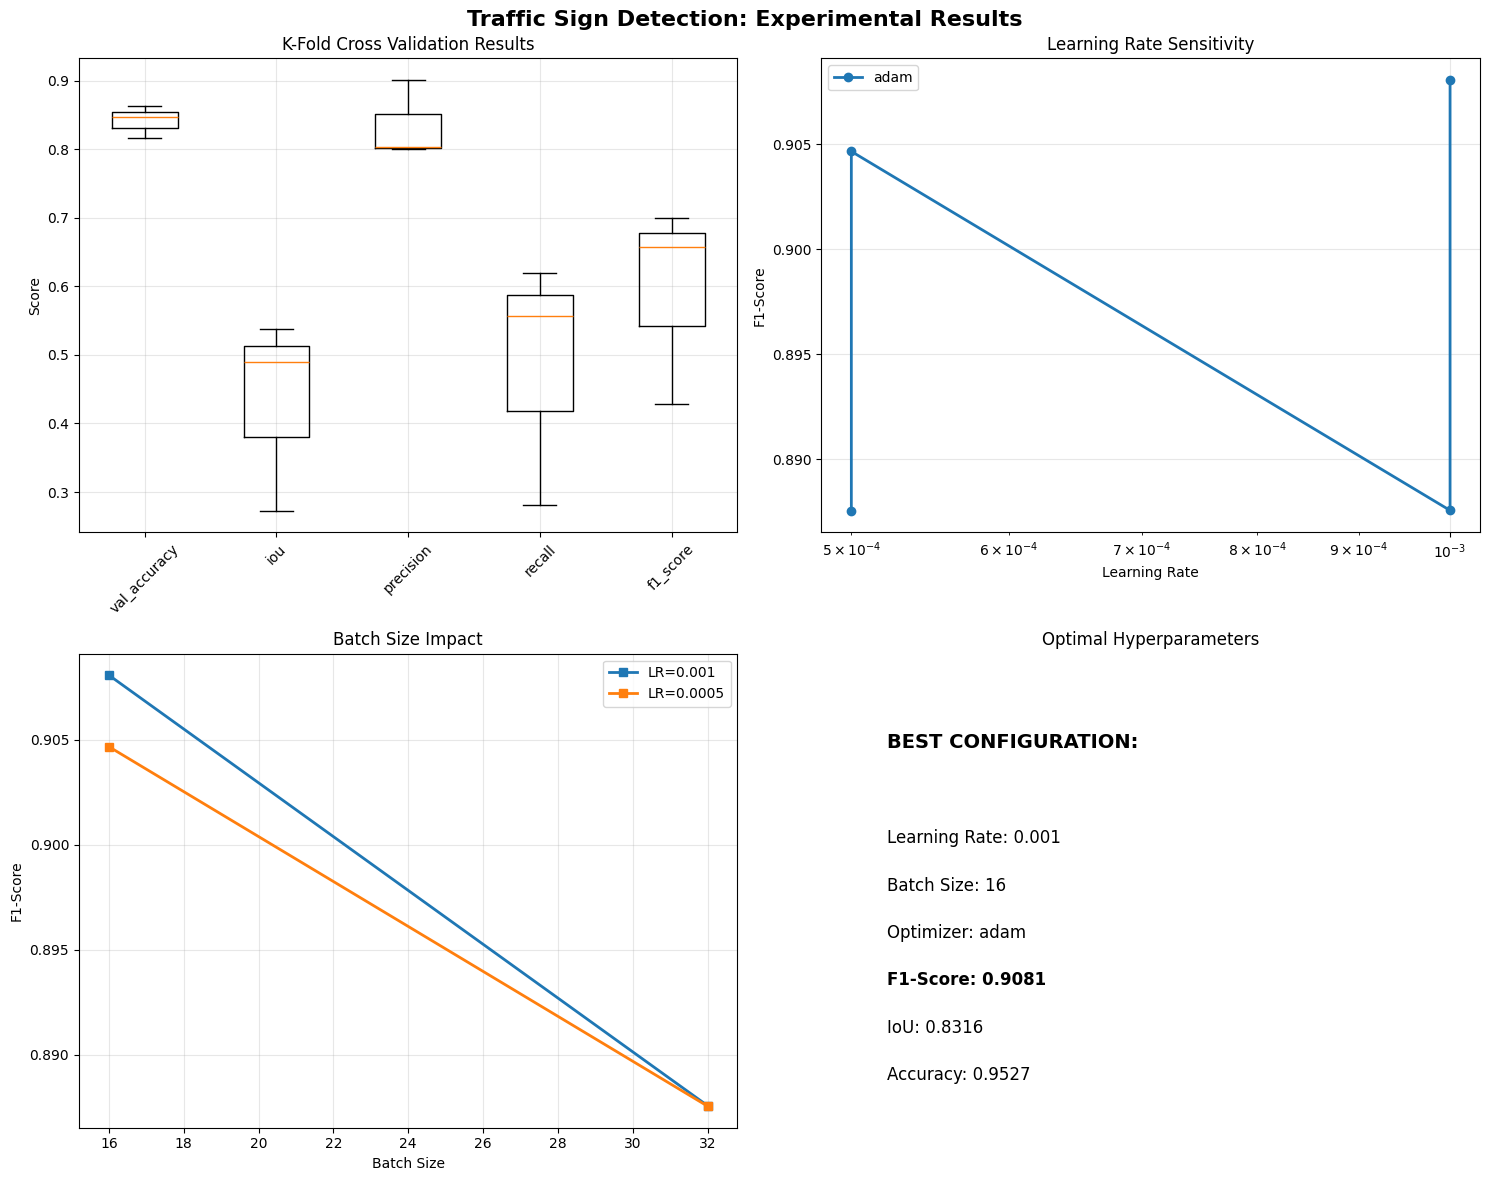

In [32]:
plot_experiment_results(kfold_results,hyper_results)